In [1967]:
import pandas as pd
from bs4 import BeautifulSoup
import urllib.request
import requests
import numpy as np
from datetime import datetime
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [1968]:
df = pd.read_csv('main_task.csv')
df.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781


# Вспомним описание переменных
Restaurant_id — идентификационный номер ресторана / сети ресторанов;

City — город, в котором находится ресторан;

Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;

Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;

Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);

Price Range — диапазон цен в ресторане;

Number of Reviews — количество отзывов о ресторане;

Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;

URL_TA — URL страницы ресторана на TripAdvosor;

ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [1969]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


#### только 3 столбца содержат пустые значения: Cuisine Style, Price Range, Number of Reviews

In [1970]:
# проверим тип данных в столбцах
for i in range (0,df.shape[1]):
    print ('"{}" type is {}'.format(df.columns[i], type(df.iloc[0,i])))

"Restaurant_id" type is <class 'str'>
"City" type is <class 'str'>
"Cuisine Style" type is <class 'str'>
"Ranking" type is <class 'numpy.float64'>
"Rating" type is <class 'numpy.float64'>
"Price Range" type is <class 'str'>
"Number of Reviews" type is <class 'numpy.float64'>
"Reviews" type is <class 'str'>
"URL_TA" type is <class 'str'>
"ID_TA" type is <class 'str'>


In [1971]:
# отформатируем названия столбцов для удобства
clmn_names = []
for clmn in df.columns:
    clmn_names.append(clmn.replace(' ','_').lower())
df.columns = clmn_names
df.head(3)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781


# Пройдем по признакам, проверим значения, поправим формат:

## 1. restaurant_id

In [1972]:
df.restaurant_id.value_counts()

id_436      18
id_227      18
id_633      18
id_871      18
id_585      17
            ..
id_6674      1
id_10593     1
id_8325      1
id_13636     1
id_12025     1
Name: restaurant_id, Length: 11909, dtype: int64

#### Поле с чистыми id'шниками - нужно для идентификации, пустых значений нет. 

In [1973]:
# проверим, не повторяются ли id номера в датасете
df.restaurant_id.value_counts()

id_436      18
id_227      18
id_633      18
id_871      18
id_585      17
            ..
id_6674      1
id_10593     1
id_8325      1
id_13636     1
id_12025     1
Name: restaurant_id, Length: 11909, dtype: int64

In [1974]:
# id повторяются в части кейсов, посмотрим эти повторения
df[df.restaurant_id=='id_436'].head()

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta
2955,id_436,Barcelona,"['Seafood', 'Mediterranean', 'Spanish', 'Glute...",437.0,4.5,$$ - $$$,546.0,"[['Fresh Fish', 'Perfect concept'], ['01/03/20...",/Restaurant_Review-g187497-d1592613-Reviews-La...,d1592613
4674,id_436,Copenhagen,"['European', 'Spanish', 'Mediterranean', 'Vege...",437.0,4.0,$$ - $$$,89.0,"[['Lovely restaurant', 'Great atmosphere and g...",/Restaurant_Review-g189541-d8738362-Reviews-To...,d8738362
6118,id_436,Oporto,"['European', 'Portuguese', 'Soups', 'Cafe', 'V...",437.0,4.5,$,71.0,"[['Super nice healthy and good', 'Great lunch ...",/Restaurant_Review-g189180-d9463122-Reviews-Ca...,d9463122
6215,id_436,Budapest,"['American', 'Vegetarian Friendly', 'Vegan Opt...",437.0,4.5,$,68.0,"[['Excellent', 'Best burger ever!'], ['12/05/2...",/Restaurant_Review-g274887-d10438365-Reviews-B...,d10438365
7377,id_436,Luxembourg,['Asian'],437.0,4.5,NaN,2.0,"[['ZEN'], ['06/11/2016']]",/Restaurant_Review-g190356-d743888-Reviews-Zen...,d743888


#### можно сделать вывод о том, что это сеть ресторанов, так как с 1 id они находятся в разных городах

In [1975]:
#Добавим признак, показывающий является ли ресторан сетью
res_id_counts = pd.DataFrame(df.restaurant_id.value_counts().reset_index())
res_id_counts.columns = ['res_id', 'cnts']
res_id_counts = res_id_counts[res_id_counts.cnts>1]
res_id_counts = res_id_counts.res_id.tolist()
res_id_counts

df['is_network'] = df.restaurant_id.apply(lambda x: 1 if x in res_id_counts else 0)
df.head()

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta,is_network
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,1
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,1
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,1


#### Больше с признаком делать ничего не будем

## 2. city

In [1976]:
df.city.value_counts()

London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: city, dtype: int64

In [1977]:
city_sorted = sorted(df.city.unique())
print(len(city_sorted))
city_sorted

31


['Amsterdam',
 'Athens',
 'Barcelona',
 'Berlin',
 'Bratislava',
 'Brussels',
 'Budapest',
 'Copenhagen',
 'Dublin',
 'Edinburgh',
 'Geneva',
 'Hamburg',
 'Helsinki',
 'Krakow',
 'Lisbon',
 'Ljubljana',
 'London',
 'Luxembourg',
 'Lyon',
 'Madrid',
 'Milan',
 'Munich',
 'Oporto',
 'Oslo',
 'Paris',
 'Prague',
 'Rome',
 'Stockholm',
 'Vienna',
 'Warsaw',
 'Zurich']

#### Итого, список городов состоит из уникальных значений,  некорректно написанных/сокращенных названий нет, пропусков нет.
#### Так как в списке больше 20 стран, для дальнейшей обработки (перейдем к дамми-переменным) нужно сгруппировать знаяения, например до уровня Регионов Европы

In [1978]:
# словарь стран Европы
dict_Europe = {}
dict_Europe['Netherlands'] = ['Amsterdam']
dict_Europe['Greece'] = ['Athens']
dict_Europe['Spain'] = ['Barcelona', 'Madrid']
dict_Europe['Germany'] = ['Berlin', 'Hamburg', 'Munich']
dict_Europe['Slovakia'] = ['Bratislava']
dict_Europe['Belgium'] = ['Brussels']
dict_Europe['Hungary'] = ['Budapest']
dict_Europe['Denmark'] = ['Copenhagen']
dict_Europe['Ireland'] = ['Dublin']
dict_Europe['Scotland'] = ['Edinburgh']
dict_Europe['Switzerland'] = ['Geneva', 'Zurich']
dict_Europe['Finland'] = ['Helsinki']
dict_Europe['Poland'] = ['Krakow', 'Warsaw']
dict_Europe['Portugal'] = ['Lisbon', 'Oporto']
dict_Europe['Slovenia'] = ['Ljubljana']
dict_Europe['England'] = ['London']
dict_Europe['Luxembourg'] = ['Luxembourg']
dict_Europe['France'] = ['Lyon', 'Paris']
dict_Europe['Italy'] = ['Milan', 'Rome']
dict_Europe['Norway'] = ['Oslo']
dict_Europe['Czech Republic'] = ['Prague']
dict_Europe['Sweden'] = ['Stockholm']
dict_Europe['Austria'] = ['Vienna']

In [1979]:
# словарь регионов Европы
dict_Europe_Parts = {}
dict_Europe_Parts['West_Europe']= ['Austria','Belgium','England','Germany','Ireland','Luxembourg', 'Netherlands','France','Switzerland','Scotland']
dict_Europe_Parts['East_Europe']= ['Hungary','Poland','Slovakia','Czech Republic']
dict_Europe_Parts['North_Europe']= ['Denmark','Ireland','Norway','Finland','Sweden']
dict_Europe_Parts['South_Europe']= ['Greece','Spain','Italy','Portugal','Slovenia']

In [1980]:
# функция для определения региона Европы
def get_country (cty):
    for k,v in dict_Europe.items():
        if cty in v:
            ctry = k
            for p,c in dict_Europe_Parts.items():
                if ctry in c:
                    res = p
                    break
            break
        else:
            res = 'wrong!'
    return res

In [1981]:
df['region'] = df.city.apply(get_country)

In [1982]:
df['West_Europe'] = df.region.apply(lambda x: 1 if x == 'West_Europe' else 0)
df['East_Europe'] = df.region.apply(lambda x: 1 if x == 'East_Europe' else 0)
df['North_Europe'] = df.region.apply(lambda x: 1 if x == 'North_Europe' else 0)
df['South_Europe'] = df.region.apply(lambda x: 1 if x == 'South_Europe' else 0)

In [1983]:
df = df.drop('region',axis=1)

In [1984]:
df.head()

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta,is_network,West_Europe,East_Europe,North_Europe,South_Europe
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,1,1,0,0,0
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1,0,0,1,0
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,1,1,0,0,0
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1,1,0,0,0
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,1,1,0,0,0


## 3. cuisine_style и price_range

In [1985]:
df.cuisine_style.value_counts()

['Italian']                                                                             1032
['French']                                                                               805
['Spanish']                                                                              695
['French', 'European']                                                                   405
['Cafe']                                                                                 403
                                                                                        ... 
['Mediterranean', 'Middle Eastern', 'Turkish', 'Halal', 'Vegetarian Friendly']             1
['Contemporary', 'Mediterranean']                                                          1
['Wine Bar', 'Italian', 'Mediterranean']                                                   1
['Asian', 'Vietnamese', 'Fusion', 'Healthy', 'Vegetarian Friendly', 'Vegan Options']       1
['European', 'Croatian', 'Vegetarian Friendly']                       

In [1986]:
def chnge_to_list (lst):
    if pd.isnull(lst):
        return None
    else:
        res = lst.replace('[','').replace(']','').replace("'",'').split(', ')
    return res

In [1987]:
df.cuisine_style = df.cuisine_style.apply(chnge_to_list)

In [1988]:
df.cuisine_style.tolist()

[['European', 'French', 'International'],
 None,
 ['Japanese',
  'Sushi',
  'Asian',
  'Grill',
  'Vegetarian Friendly',
  'Vegan Options',
  'Gluten Free Options'],
 None,
 ['German', 'Central European', 'Vegetarian Friendly'],
 None,
 ['Italian', 'Pizza'],
 ['Italian'],
 None,
 ['Italian', 'Pizza', 'Fast Food'],
 None,
 ['Italian', 'Pizza', 'Vegetarian Friendly'],
 ['Italian', 'Pizza', 'Vegetarian Friendly', 'Gluten Free Options'],
 ['Vegetarian Friendly', 'Gluten Free Options'],
 ['Mediterranean', 'Spanish', 'Healthy'],
 ['Cafe'],
 ['Japanese', 'Asian', 'Thai', 'Vietnamese'],
 ['Bar', 'Pub'],
 ['German'],
 ['Chinese'],
 ['German', 'Vegetarian Friendly'],
 None,
 ['Bar', 'British', 'Pub'],
 ['Asian',
  'Thai',
  'Vegetarian Friendly',
  'Gluten Free Options',
  'Vegan Options'],
 ['Cafe', 'British'],
 ['Polish', 'International', 'European', 'Fusion'],
 None,
 None,
 None,
 None,
 None,
 ['Dutch', 'European'],
 None,
 ['Vietnamese'],
 ['Italian', 'Pizza'],
 ['Italian', 'Mexican', 'Ven

In [1989]:
# создаем список всех типов кухонь, встречающихся в датасете
c_style_full_list = set()
tmp = df.cuisine_style.tolist()
for c_s in tmp:
    if c_s is None:
        continue
    else:
        for i in range(len(c_s)):
            c_style_full_list.add(c_s[i])
c_style_full_list

{'Afghani',
 'African',
 'Albanian',
 'American',
 'Arabic',
 'Argentinean',
 'Armenian',
 'Asian',
 'Australian',
 'Austrian',
 'Azerbaijani',
 'Balti',
 'Bangladeshi',
 'Bar',
 'Barbecue',
 'Belgian',
 'Brazilian',
 'Brew Pub',
 'British',
 'Burmese',
 'Cafe',
 'Cajun & Creole',
 'Cambodian',
 'Canadian',
 'Caribbean',
 'Caucasian',
 'Central American',
 'Central Asian',
 'Central European',
 'Chilean',
 'Chinese',
 'Colombian',
 'Contemporary',
 'Croatian',
 'Cuban',
 'Czech',
 'Danish',
 'Delicatessen',
 'Diner',
 'Dutch',
 'Eastern European',
 'Ecuadorean',
 'Egyptian',
 'Ethiopian',
 'European',
 'Fast Food',
 'Filipino',
 'French',
 'Fujian',
 'Fusion',
 'Gastropub',
 'Georgian',
 'German',
 'Gluten Free Options',
 'Greek',
 'Grill',
 'Halal',
 'Hawaiian',
 'Healthy',
 'Hungarian',
 'Indian',
 'Indonesian',
 'International',
 'Irish',
 'Israeli',
 'Italian',
 'Jamaican',
 'Japanese',
 'Korean',
 'Kosher',
 'Latin',
 'Latvian',
 'Lebanese',
 'Malaysian',
 'Mediterranean',
 'Mexic

In [1990]:
len(c_style_full_list)

125

In [1991]:
c_style_full_dict = dict()

In [1992]:
real_list =df[df.cuisine_style.isna()==False].cuisine_style.tolist()

In [1993]:
for cs in real_list:
    for rcs in cs:
        if rcs in c_style_full_dict.keys():
            ctr = c_style_full_dict[rcs]
            c_style_full_dict[rcs] = ctr + 1
        else:
            c_style_full_dict[rcs] = 1
c_style_full_dict

{'European': 10060,
 'French': 3190,
 'International': 1584,
 'Japanese': 1464,
 'Sushi': 1156,
 'Asian': 3011,
 'Grill': 490,
 'Vegetarian Friendly': 11189,
 'Vegan Options': 4486,
 'Gluten Free Options': 4113,
 'German': 662,
 'Central European': 1393,
 'Italian': 5964,
 'Pizza': 2849,
 'Fast Food': 1705,
 'Mediterranean': 6277,
 'Spanish': 2798,
 'Healthy': 620,
 'Cafe': 2325,
 'Thai': 743,
 'Vietnamese': 513,
 'Bar': 3297,
 'Pub': 2449,
 'Chinese': 1145,
 'British': 1595,
 'Polish': 365,
 'Fusion': 577,
 'Dutch': 294,
 'Mexican': 445,
 'Venezuelan': 40,
 'South American': 372,
 'Soups': 494,
 'Belgian': 270,
 'Steakhouse': 573,
 'Latin': 302,
 'Barbecue': 555,
 'Argentinean': 169,
 'Irish': 284,
 'Seafood': 1505,
 'Swiss': 178,
 'Portuguese': 1107,
 'Contemporary': 523,
 'Wine Bar': 697,
 'Greek': 604,
 'Central American': 135,
 'Indian': 1041,
 'Middle Eastern': 782,
 'Turkish': 444,
 'Hungarian': 352,
 'Pakistani': 123,
 'Peruvian': 94,
 'Delicatessen': 392,
 'Eastern European': 

In [1994]:
max_cs = max(c_style_full_dict.values())
max_cs_dict = dict()
for k,v in c_style_full_dict.items():
    if v == max_cs:
        max_cs_dict[k] = v
max_cs_dict

{'Vegetarian Friendly': 11189}

In [1995]:
def count_av_cs(cs):
    if cs is None:
        return 0
    else:
        for c in cs:
            return(len(cs))

In [1996]:
df['c_s_average_cnt'] = df.cuisine_style.apply(count_av_cs)

In [1997]:
df.c_s_average_cnt.mean()

2.390325

In [1998]:
df.cuisine_style.isna().value_counts()

False    30717
True      9283
Name: cuisine_style, dtype: int64

#### порядка 9,2 тысяч записей - пстые

In [1573]:
df_with_none = df[df.cuisine_style.isna()]
df_with_none

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta,is_network,West_Europe,East_Europe,North_Europe,South_Europe,c_s_average_cnt
1,id_1535,Stockholm,None,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1,0,0,1,0,0
3,id_3456,Berlin,None,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1,1,0,0,0,0
5,id_1418,Oporto,None,1419.0,3.0,NaN,2.0,"[['There are better 3 star hotel bars', 'Amazi...",/Restaurant_Review-g189180-d12503536-Reviews-D...,d12503536,1,0,0,0,1,0
8,id_2690,Vienna,None,2692.0,4.0,NaN,NaN,"[[], []]",/Restaurant_Review-g190454-d12845029-Reviews-G...,d12845029,1,1,0,0,0,0
10,id_6578,Barcelona,None,6579.0,3.0,NaN,6.0,"[[], []]",/Restaurant_Review-g187497-d10696479-Reviews-R...,d10696479,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39981,id_924,Lyon,None,925.0,4.0,NaN,29.0,"[[], []]",/Restaurant_Review-g187265-d5850306-Reviews-Re...,d5850306,1,1,0,0,0,0
39983,id_2487,Amsterdam,None,2494.0,4.5,NaN,2.0,"[['Italian food, as in Italy!'], ['05/24/2015']]",/Restaurant_Review-g188590-d8120959-Reviews-Sa...,d8120959,1,1,0,0,0,0
39986,id_7274,Madrid,None,7279.0,3.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187514-d12182212-Reviews-C...,d12182212,1,0,0,0,1,0
39988,id_4968,Berlin,None,4970.0,4.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187323-d7761701-Reviews-Ar...,d7761701,1,1,0,0,0,0


#### так как тип кухни, как правило содержится в описании ресторана, а у нас есть ссылка на страницу конкретного ресторана, попробуем найти нужную информацию на этой странице.
#### если будем искать данные на сайте, сразу возьмем данные о ценовом диапазоне и комментарии 

In [1219]:
def get_info_url(url_address):
    response = requests.get(url_address)    
    page = BeautifulSoup(response.text, 'html.parser')   
    tmp = page.find_all('a', class_= '_2mn01bsa')
    tmp_list_1 = ([t.text for t in tmp]) 
    tmp = page.find_all('p', class_= 'partial_entry')
    tmp_list_2 = ([t.text for t in tmp])
    res = [tmp_list_1,tmp_list_2]
    return res

In [1220]:
df_with_none.head()

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta,is_network,West_Europe,East_Europe,North_Europe,South_Europe
1,id_1535,Stockholm,None,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1,0,0,1,0
3,id_3456,Berlin,None,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1,1,0,0,0
5,id_1418,Oporto,None,1419.0,3.0,NaN,2.0,"[['There are better 3 star hotel bars', 'Amazi...",/Restaurant_Review-g189180-d12503536-Reviews-D...,d12503536,1,0,0,0,1
8,id_2690,Vienna,None,2692.0,4.0,NaN,NaN,"[[], []]",/Restaurant_Review-g190454-d12845029-Reviews-G...,d12845029,1,1,0,0,0
10,id_6578,Barcelona,None,6579.0,3.0,NaN,6.0,"[[], []]",/Restaurant_Review-g187497-d10696479-Reviews-R...,d10696479,1,0,0,0,1


In [1230]:
df_with_new_info = df_with_none.head(0)
df_with_new_info['new_info'] = df_with_new_info.url_ta

In [1224]:
strt = 0
step = 100
ctr = 0

for i in range (strt,len(df_none_style.restaurant_id)+1, step):   
    if  i > step and ctr > 1:
        strt = strt + step
    df_tmp = df_with_none.iloc[strt:i,:]
   
    df_tmp['new_info'] = 'https://www.tripadvisor.com' + df_tmp.url_ta
    df_tmp['new_info'] = df_tmp.new_info.apply(get_info_url)
   
    df_with_new_info = pd.concat([df_with_new_info, df_tmp])
    ctr +=1
    print (i, '- is done at', str(datetime.datetime.now()))

In [1236]:
# полученный DF с данными, взятыми по ссылкам ресторанов на сайте tripadviser
df_with_new_info.head(2)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta,West_Europe,East_Europe,North_Europe,South_Europe,new_info
0,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,0,0,1,0,"[['$$ - $$$', 'Asian', 'Nepali'], [""Nepali dec..."
1,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1,0,0,0,"[[], ['', 'More', 'More']]"


In [1237]:
def parse_new_price (nf):
    nf = chnge_to_list(nf)
    if nf == '':
        return None
    else:
        pattern = re.compile('\$*\s\-\s\$*')
        res = pattern.search(nf[0])
        if res is None:
            pattern = re.compile('\$*')
            res = pattern.search(nf[0])
        if res is None:
            return None
        else:
            return res.group(0)

In [1238]:
def parse_new_cstyle (nf):
    nf = chnge_to_list(nf)
    if nf == []:
        return None
    else:
        res = nf[1:]
        if res is None:
            return None
        else:
            fin_res = []
            for fd in res:
                if fd in c_style_full_list:
                    if fd == [] or fd == 'More' or fd == '':
                        continue
                    else:
                        fin_res.append(fd)
            if fin_res != []:
                return fin_res
            else:
                return None

In [1435]:
df_with_new_info['new_price'] = df_with_new_info.new_info.apply(parse_new_price)

In [1437]:
df_with_new_info['new_cstyle'] = df_with_new_info.new_info.apply(parse_new_cstyle)

In [1438]:
df_with_new_info['c_style_new'] = df_with_new_info['cuisine_style'].where(df_with_new_info['new_cstyle'].isnull(), df_with_new_info['new_cstyle'])


In [1439]:
df_with_new_info['price_range_new'] = df_with_new_info['price_range'].where(df_with_new_info['new_price'].isnull(), df_with_new_info['new_price'])


In [1440]:
df_with_new_info.c_style_new.isna().value_counts()

True     5262
False    4021
Name: c_style_new, dtype: int64

In [1244]:
df_with_new_info.head(3)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta,West_Europe,East_Europe,North_Europe,South_Europe,new_info,new_price,new_cstyle,c_style_new,price_range_new
0,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,0,0,1,0,"[['$$ - $$$', 'Asian', 'Nepali'], [""Nepali dec...",$$ - $$$,"[Asian, Nepali]","[Asian, Nepali]",$$ - $$$
1,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1,0,0,0,"[[], ['', 'More', 'More']]",,None,NaN,
2,id_1418,Oporto,NaN,1419.0,3.0,NaN,2.0,"[['There are better 3 star hotel bars', 'Amazi...",/Restaurant_Review-g189180-d12503536-Reviews-D...,d12503536,0,0,0,1,"[['$$ - $$$', 'Bar', 'Portuguese'], [""Dick's b...",$$ - $$$,"[Bar, Portuguese]","[Bar, Portuguese]",$$ - $$$


In [1999]:
df = df.join(df_with_new_info[['c_style_new', 'price_range_new']])

In [2000]:
df['cusine_style_fin'] = df['cuisine_style'].where(df['c_style_new'].isnull(), df['c_style_new'])
df['price_range_fin'] = df['price_range'].where(df['price_range_new'].isnull(), df['price_range_new'])
df.drop(['cuisine_style','price_range','price_range_new', 'c_style_new','price_range_new'], axis = 1, inplace = True)

In [2001]:
df.head(3)

,restaurant_id,city,ranking,rating,number_of_reviews,reviews,url_ta,id_ta,is_network,West_Europe,East_Europe,North_Europe,South_Europe,c_s_average_cnt,cusine_style_fin,price_range_fin
0,id_5569,Paris,5570.0,3.5,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,1,1,0,0,0,3,"[Asian, Nepali]",$$ - $$$
1,id_1535,Stockholm,1537.0,4.0,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1,0,0,1,0,0,None,
2,id_352,London,353.0,4.5,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,1,1,0,0,0,7,"[Bar, Portuguese]",$$ - $$$


In [2002]:
df.cusine_style_fin.isna().value_counts()

False    31666
True      8334
Name: cusine_style_fin, dtype: int64

 #### с типом кухни ситуация улучшилась, но осталось порядка 8 тысяч пустых записей

In [2003]:
df.price_range_fin.isna().value_counts()

False    29299
True     10701
Name: price_range_fin, dtype: int64

#### с ценовым диапазоном ситуация улучшилась ненамного, осталось еще  10701 пустая запись

#### посчитаем количество кухонь на 1 ресторан

In [2004]:
df['c_s_average_cnt'] = df.cusine_style_fin.apply(count_av_cs)

In [2005]:
df.c_s_average_cnt.value_counts()

0     8334
1     8107
2     6870
3     5999
4     4370
5     3235
6     1824
7      907
8      258
9       73
10      18
11       3
21       1
13       1
Name: c_s_average_cnt, dtype: int64

In [2006]:
df.head(3)

,restaurant_id,city,ranking,rating,number_of_reviews,reviews,url_ta,id_ta,is_network,West_Europe,East_Europe,North_Europe,South_Europe,c_s_average_cnt,cusine_style_fin,price_range_fin
0,id_5569,Paris,5570.0,3.5,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,1,1,0,0,0,2,"[Asian, Nepali]",$$ - $$$
1,id_1535,Stockholm,1537.0,4.0,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1,0,0,1,0,0,None,
2,id_352,London,353.0,4.5,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,1,1,0,0,0,2,"[Bar, Portuguese]",$$ - $$$


In [2007]:
df.price_range_fin.value_counts()

$$ - $$$    16916
$            6782
             4409
$$$$         1192
Name: price_range_fin, dtype: int64

#### подавляющее большинство значений представлен выше - заменим пустые значения на него

In [2008]:
df.price_range_fin.fillna('$$ - $$$', inplace = True)
df.price_range_fin = df.price_range_fin.apply(lambda x: '$$ - $$$' if x == '' else x)

In [2009]:
df.price_range_fin.value_counts()

$$ - $$$    32026
$            6782
$$$$         1192
Name: price_range_fin, dtype: int64

#### создладим столбец с признаком группы цен: 1 - дешево, 2 - средне, 3 - дорого

In [2010]:
df['price_range_group'] = df.price_range_fin.apply(lambda x: 1 if x == '$' 
                                                             else 2 if x == '$$ - $$$'
                                                             else 3)

In [2011]:
df.drop('price_range_fin', inplace = True, axis = 1)

In [2012]:
df.head(3)

,restaurant_id,city,ranking,rating,number_of_reviews,reviews,url_ta,id_ta,is_network,West_Europe,East_Europe,North_Europe,South_Europe,c_s_average_cnt,cusine_style_fin,price_range_group
0,id_5569,Paris,5570.0,3.5,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,1,1,0,0,0,2,"[Asian, Nepali]",2
1,id_1535,Stockholm,1537.0,4.0,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1,0,0,1,0,0,None,2
2,id_352,London,353.0,4.5,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,1,1,0,0,0,2,"[Bar, Portuguese]",2


## 4. Reviews

In [2013]:
df.reviews = df.reviews.apply(chnge_to_list)

In [2014]:
#посмотрим на значения Reviews
res = []

for i in range(30):
    res.append(df.reviews.loc[i])
res

[['Good food at your doorstep',
  'A good hotel restaurant',
  '12/31/2017',
  '11/20/2017'],
 ['Unique cuisine', 'Delicious Nepalese food', '07/06/2017', '06/19/2016'],
 ['Catch up with friends', 'Not exceptional', '01/08/2018', '01/06/2018'],
 ['', ''],
 ['Best place to try a Bavarian food',
  'Nice building but improvements need to be...',
  '11/18/2017',
  '02/19/2017'],
 ['There are better 3 star hotel bars',
  'Amazing views',
  'friendly service and good q...',
  '09/16/2017',
  '05/31/2017'],
 ['Excellent simple local eatery.',
  'Excellent Restaurant',
  '08/04/2017',
  '11/05/2017'],
 ['Wasting of money', 'excellent cuisine', '02/16/2014', '06/13/2012'],
 ['', ''],
 ['Clean efficient staff',
  'Nice little pizza takeaway place',
  '11/07/2017',
  '03/27/2017'],
 ['', ''],
 ['Not bad for Canary Wharf', 'To be a pilgrim', '12/15/2017', '11/22/2017'],
 ['Great service',
  'good za',
  'Lovely',
  'relaxed atmosphere!',
  '01/07/2018',
  '12/27/2017'],
 ['What a great spot!',
  '

In [2015]:
def get_rev_start_date (rev):
    if rev is None:
        return None
    else:
        if rev[-1] == '':
            return None
        else:
            if '/' in rev[-1] and len(rev[-1])==10:
                return datetime.strptime(rev[-1], '%m/%d/%Y') 
            else:
                return None

In [2016]:
def get_rev_fin_date (rev):
    if rev is None:
        return None
    else:
        if rev[-2] == '':
            return None
        else:
            if '/' in rev[-2] and len(rev[-2])==10:
                return datetime.strptime(rev[-2], '%m/%d/%Y') 
            else:
                return None

In [2017]:
df['reviews_start_date'] = df.reviews.apply(get_rev_start_date)
df['reviews_fin_date'] = df.reviews.apply(get_rev_fin_date)

In [2018]:
df.reviews_start_date.fillna(df.reviews_start_date.mean(), inplace = True)
df.reviews_fin_date.fillna(df.reviews_fin_date.mean(), inplace = True)

In [2019]:
df['reviews_fin_date'].max()

Timestamp('2018-02-26 00:00:00')

In [2020]:
df.reviews_start_date = df.reviews_start_date.apply(lambda x: int(time.mktime(x.timetuple())))
df.reviews_fin_date = df.reviews_fin_date.apply(lambda x: int(time.mktime(x.timetuple())))

In [2021]:
df['reviews_date_delta'] = df.reviews_fin_date - df.reviews_start_date 

In [2022]:
df.head(3)

,restaurant_id,city,ranking,rating,number_of_reviews,reviews,url_ta,id_ta,is_network,West_Europe,East_Europe,North_Europe,South_Europe,c_s_average_cnt,cusine_style_fin,price_range_group,reviews_start_date,reviews_fin_date,reviews_date_delta
0,id_5569,Paris,5570.0,3.5,194.0,"[Good food at your doorstep, A good hotel rest...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,1,1,0,0,0,2,"[Asian, Nepali]",2,1511125200,1514667600,3542400
1,id_1535,Stockholm,1537.0,4.0,10.0,"[Unique cuisine, Delicious Nepalese food, 07/0...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1,0,0,1,0,0,None,2,1466283600,1499288400,33004800
2,id_352,London,353.0,4.5,688.0,"[Catch up with friends, Not exceptional, 01/08...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,1,1,0,0,0,2,"[Bar, Portuguese]",2,1515186000,1515358800,172800


## 5. Ranking

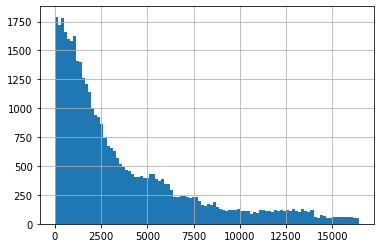

In [2023]:
# числовой признак, посмотрим на распределение
df.ranking.hist(bins=100)

#### Судя по распределению, никаких явных выбросов нет. Оставим признак как есть.

## 6. Raiting

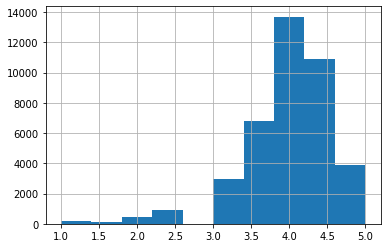

In [2024]:
df.rating.hist()

#### В целевой переменной также не видно явных выбросов - все оценки от 1 до 5.

## 7. number_of_reviews

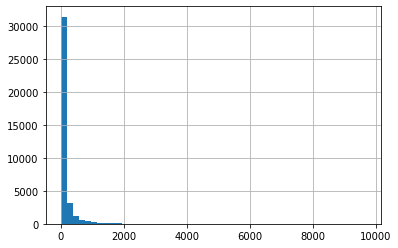

In [2025]:
df.number_of_reviews.hist(bins = 50)

In [2026]:
df[df.number_of_reviews<0]

,restaurant_id,city,ranking,rating,number_of_reviews,reviews,url_ta,id_ta,is_network,West_Europe,East_Europe,North_Europe,South_Europe,c_s_average_cnt,cusine_style_fin,price_range_group,reviews_start_date,reviews_fin_date,reviews_date_delta


In [2027]:
df.number_of_reviews.isna().value_counts()

False    37457
True      2543
Name: number_of_reviews, dtype: int64

In [2028]:
df[df.number_of_reviews.isna()==True]

,restaurant_id,city,ranking,rating,number_of_reviews,reviews,url_ta,id_ta,is_network,West_Europe,East_Europe,North_Europe,South_Europe,c_s_average_cnt,cusine_style_fin,price_range_group,reviews_start_date,reviews_fin_date,reviews_date_delta
8,id_2690,Vienna,2692.0,4.0,NaN,"[, ]",/Restaurant_Review-g190454-d12845029-Reviews-G...,d12845029,1,1,0,0,0,0,None,2,1484668867,1498670541,14001674
21,id_5844,Madrid,5847.0,4.0,NaN,"[, ]",/Restaurant_Review-g187514-d10058810-Reviews-B...,d10058810,1,0,0,0,1,0,None,2,1484668867,1498670541,14001674
32,id_1327,Budapest,1328.0,5.0,NaN,"[Absolutely amazing, tasty, fresh, cheap Ch......",/Restaurant_Review-g274887-d8791087-Reviews-Bu...,d8791087,1,0,1,0,0,2,"[French, European]",1,1445806800,1498670541,52863741
102,id_1409,Budapest,1410.0,5.0,NaN,"[, ]",/Restaurant_Review-g274887-d13197631-Reviews-L...,d13197631,1,0,1,0,0,3,"[French, European, Hungarian]",2,1484668867,1498670541,14001674
108,id_2047,Prague,2050.0,5.0,NaN,"[, ]",/Restaurant_Review-g274707-d12243659-Reviews-T...,d12243659,1,0,1,0,0,2,"[Italian, Mediterranean]",2,1484668867,1498670541,14001674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39965,id_5720,Rome,5722.0,5.0,NaN,"[, ]",/Restaurant_Review-g187791-d793376-Reviews-Wes...,d793376,1,0,0,0,1,0,None,2,1484668867,1498670541,14001674
39972,id_2009,Prague,2012.0,5.0,NaN,"[Personal expirence, 10/27/2017]",/Restaurant_Review-g274707-d12981295-Reviews-M...,d12981295,1,0,1,0,0,5,"[Cafe, Delicatessen, Healthy, Wine Bar, Street...",1,1509051600,1498670541,-10381059
39986,id_7274,Madrid,7279.0,3.0,NaN,"[, ]",/Restaurant_Review-g187514-d12182212-Reviews-C...,d12182212,1,0,0,0,1,0,None,2,1484668867,1498670541,14001674
39988,id_4968,Berlin,4970.0,4.0,NaN,"[, ]",/Restaurant_Review-g187323-d7761701-Reviews-Ar...,d7761701,1,1,0,0,0,0,None,2,1484668867,1498670541,14001674


#### проверим наличие отзывов - если они есть внесем кол-во отзывов, если нет - ставим 0

In [2029]:
def rev_counter(rev):
    ctr = 0
    for rv in rev:
        if rv != '':
            ctr +=1
    return ctr

In [2030]:
df['rev_count'] = df.reviews.apply(rev_counter)

In [2031]:
df[df.number_of_reviews.isna()==True]

,restaurant_id,city,ranking,rating,number_of_reviews,reviews,url_ta,id_ta,is_network,West_Europe,East_Europe,North_Europe,South_Europe,c_s_average_cnt,cusine_style_fin,price_range_group,reviews_start_date,reviews_fin_date,reviews_date_delta,rev_count
8,id_2690,Vienna,2692.0,4.0,NaN,"[, ]",/Restaurant_Review-g190454-d12845029-Reviews-G...,d12845029,1,1,0,0,0,0,None,2,1484668867,1498670541,14001674,0
21,id_5844,Madrid,5847.0,4.0,NaN,"[, ]",/Restaurant_Review-g187514-d10058810-Reviews-B...,d10058810,1,0,0,0,1,0,None,2,1484668867,1498670541,14001674,0
32,id_1327,Budapest,1328.0,5.0,NaN,"[Absolutely amazing, tasty, fresh, cheap Ch......",/Restaurant_Review-g274887-d8791087-Reviews-Bu...,d8791087,1,0,1,0,0,2,"[French, European]",1,1445806800,1498670541,52863741,5
102,id_1409,Budapest,1410.0,5.0,NaN,"[, ]",/Restaurant_Review-g274887-d13197631-Reviews-L...,d13197631,1,0,1,0,0,3,"[French, European, Hungarian]",2,1484668867,1498670541,14001674,0
108,id_2047,Prague,2050.0,5.0,NaN,"[, ]",/Restaurant_Review-g274707-d12243659-Reviews-T...,d12243659,1,0,1,0,0,2,"[Italian, Mediterranean]",2,1484668867,1498670541,14001674,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39965,id_5720,Rome,5722.0,5.0,NaN,"[, ]",/Restaurant_Review-g187791-d793376-Reviews-Wes...,d793376,1,0,0,0,1,0,None,2,1484668867,1498670541,14001674,0
39972,id_2009,Prague,2012.0,5.0,NaN,"[Personal expirence, 10/27/2017]",/Restaurant_Review-g274707-d12981295-Reviews-M...,d12981295,1,0,1,0,0,5,"[Cafe, Delicatessen, Healthy, Wine Bar, Street...",1,1509051600,1498670541,-10381059,2
39986,id_7274,Madrid,7279.0,3.0,NaN,"[, ]",/Restaurant_Review-g187514-d12182212-Reviews-C...,d12182212,1,0,0,0,1,0,None,2,1484668867,1498670541,14001674,0
39988,id_4968,Berlin,4970.0,4.0,NaN,"[, ]",/Restaurant_Review-g187323-d7761701-Reviews-Ar...,d7761701,1,1,0,0,0,0,None,2,1484668867,1498670541,14001674,0


In [2032]:
df['number_of_reviews_fin'] = df['rev_count'].where(df['number_of_reviews'].isnull(), df['number_of_reviews'])


In [2033]:
df.number_of_reviews_fin.isna().value_counts()

False    40000
Name: number_of_reviews_fin, dtype: int64

## Соберем итоговую таблицу

In [2034]:
df.head()

,restaurant_id,city,ranking,rating,number_of_reviews,reviews,url_ta,id_ta,is_network,West_Europe,...,North_Europe,South_Europe,c_s_average_cnt,cusine_style_fin,price_range_group,reviews_start_date,reviews_fin_date,reviews_date_delta,rev_count,number_of_reviews_fin
0,id_5569,Paris,5570.0,3.5,194.0,"[Good food at your doorstep, A good hotel rest...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,1,1,...,0,0,2,"[Asian, Nepali]",2,1511125200,1514667600,3542400,4,194
1,id_1535,Stockholm,1537.0,4.0,10.0,"[Unique cuisine, Delicious Nepalese food, 07/0...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1,0,...,1,0,0,None,2,1466283600,1499288400,33004800,4,10
2,id_352,London,353.0,4.5,688.0,"[Catch up with friends, Not exceptional, 01/08...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,1,1,...,0,0,2,"[Bar, Portuguese]",2,1515186000,1515358800,172800,4,688
3,id_3456,Berlin,3458.0,5.0,3.0,"[, ]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1,1,...,0,0,1,[European],2,1484668867,1498670541,14001674,0,3
4,id_615,Munich,621.0,4.0,84.0,"[Best place to try a Bavarian food, Nice build...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,1,1,...,0,0,1,[Spanish],1,1487451600,1510952400,23500800,4,84


#### restaurant_id и id_ta - представляют собой уникальные id и не могут нести зависимостей, удаляем
#### city - заменили на новые столбцы принадлежности к региону Европы. удаляем
#### reviews - на текущий момент непонятно, как использовать, удаляем
#### url_ta - уникальные ссылки на рестораны, не несут зависимости, удаляем
#### number_of_reviews - заменили на новый столбец (без пустых)
#### cusine_style_fin - технические поля, убираем
#### Все остальные поля - оставляем для анализа

In [2036]:
df.drop(['restaurant_id', 
         'id_ta', 
         'city', 
         'reviews', 
         'url_ta', 
         'number_of_reviews', 
         'cusine_style_fin'], inplace = True, axis = 1)

In [2037]:
df.head(3)

,ranking,rating,is_network,West_Europe,East_Europe,North_Europe,South_Europe,c_s_average_cnt,price_range_group,reviews_start_date,reviews_fin_date,reviews_date_delta,rev_count,number_of_reviews_fin
0,5570.0,3.5,1,1,0,0,0,2,2,1511125200,1514667600,3542400,4,194
1,1537.0,4.0,1,0,0,1,0,0,2,1466283600,1499288400,33004800,4,10
2,353.0,4.5,1,1,0,0,0,2,2,1515186000,1515358800,172800,4,688


In [2038]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
ranking                  40000 non-null float64
rating                   40000 non-null float64
is_network               40000 non-null int64
West_Europe              40000 non-null int64
East_Europe              40000 non-null int64
North_Europe             40000 non-null int64
South_Europe             40000 non-null int64
c_s_average_cnt          40000 non-null int64
price_range_group        40000 non-null int64
reviews_start_date       40000 non-null int64
reviews_fin_date         40000 non-null int64
reviews_date_delta       40000 non-null int64
rev_count                40000 non-null int64
number_of_reviews_fin    40000 non-null int64
dtypes: float64(2), int64(12)
memory usage: 4.3 MB


## Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [2039]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop('rating', axis = 1)
y = df['rating']

In [2040]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [2041]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Создаём, обучаем и тестируем модель

In [2042]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [2043]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [2044]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.3118394333333333
